##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib notebook

# %matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass



from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD','fco2':'fco2',
        'Out_of_Basin':'F$_{Upland}$','Upland':'F$_{Upland}$',#'F$_{up}$',
        'Sedge':'F$_{Sedge}$','Shrub':'F$_{Shrub}$',#'F$_{shb}$',
        'Sparse':'Sparse','Grass':'F$_{Grass}$',#'F$_{grs}$',
        'HR':'Hour','DOY':'DOY',
        'NR_Wm2_Avg':'NR_Wm2_Avg','Temp':'T$_{s}$','H':'$H$','VPD':'VPD','VWC':'$VWC$',
        'Water Table': 'W$_{TBL}$','Active Layer':'AL',
        'AirTC_Avg':'T$_{a}$','air_pressure':'P$_{a}$',
        'Wind Spd':'$\overline{U}$','24H Rain':'24HR','Wtr Tbl Trnd':'d Wtr Tbl',
        'air pressure':'P$_{a}$','Ta':'T$_{a}$','Rn':'Rn','PPFD':'PPFD','Rain':'Rain',
        'Ts 2.5 cm':'T$_{2.5cm}$','Ts 15 cm':'T$_{15cm}$','(z-d)/L':'Stability'}

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
Path='Data'

Using TensorFlow backend.


In [2]:
class ResultMap:
    def __init__(self,target,Test='SE',Rule=1,alpha = .025,AltPath=None):
        self.Rule = Rule
        self.target = target        
        self.params = Dense.Params('Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Path+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,'ECData.csv')#,resample='2H')
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += self.target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Number'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Records['SE']
        Names = []
        rem = []
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.Records['T2']=0
        self.Records['Select'] = 0
        for j in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==j]
            if j == 1:
                self.level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
            else:
                try:
                    self.level_best = self.level_best.append(Level.loc[Level['MSE']==Level['MSE'].min()])
                except:
                    self.level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                    pass
            ##T-test
            if Test == 'T':
                Sv = (((Level['SE']**2+self.Min['SE'].values[0]**2)/2)**.5)
                Level['T2']=(Level['MSE']-self.Min['MSE'].values[0])/(Sv*(2/self.params['K'])**.5)

                Level.loc[Level['T2'].abs()<=stats.t.ppf(1-alpha,self.params['K']),'Select']+=1
            ##SE-Rule
            if Test == 'RMSE':
                Level.loc[Level['RMSE']<=self.Min['RMSE'].values[0]+.1,'Select']+=1
            elif Test == 'SE':
                Level.loc[Level['MSE']<=self.Min['MSE'].values[0]+self.Min['SE'].values[0]*Rule,'Select']+=1
            elif Test == 'PCT':
                Level.loc[Level['MSE']<=self.Min['MSE'].values[0]+Rule,'Select']+=1
            elif Test == 'Thresh':
                self.Min = self.Records.loc[self.Records['Thresh']==self.Records['Thresh'].min()]
                Level.loc[Level['Thresh']<=self.Min['Thresh'].values[0],'Select']+=1
            else:
                self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
                Level.loc[Level['MSE']<=self.Min['MSE'].values[0],'Select']+=1
            self.Records.loc[self.Records['Size']==j]=Level
        Trecords = self.Records.loc[self.Records['Select']==self.Records['Select'].max()]
        self.Best = Trecords.loc[Trecords['Size']==Trecords['Size'].min()]
        if Test == 'Thresh':
            self.Best = self.Best.loc[self.Best['Thresh']==self.Best['Thresh'].min()]
        else:
            self.Best = self.Best.loc[self.Best['MSE']==self.Best['MSE'].min()]
            
        self.Model_Selection = self.Best.loc[self.Best['MSE'] == self.Best['MSE'].min(), 'Model'].values[0]
            
#         for level in self.Records['Size'].unique():
#             Level = self.Records.loc[self.Records['Size']==level]

                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
#         print()
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
#         prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
#         display(prog1)
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.params['K']))):
#                 prog1.value+=1
                Y = results
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        pool = Pool(processes=1,maxtasksperchild=75)
        YVar = Dense.Load_Model(i=0,X=X,params=self.params)
        YVar = self.RST.YvarScaled.inverse_transform(YVar) 
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(0,1))):
            YVar = results
            YVar = self.RST.YvarScaled.inverse_transform(YVar)                    
        pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
     

In [3]:
def Performance(ax,title,target,verbose,lim=None):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
            yerr=target.level_best['SE'].values*target.Rule,color='grey',
            alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.Rule,
           color='red',alpha = 1,label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule])
    plt.sca(ax)
    plt.grid()
    if lim is not None:
        ax.set_xlim(lim)
        yaxy.set_xlim(lim)
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        print(i,mod)
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
    else:
#         alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',alpha = 1,label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',alpha = 1,label='Parsimony')
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
    ax.grid()
    print(Data)

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
#     print(AllData[name])
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<IPython.core.display.Javascript object>


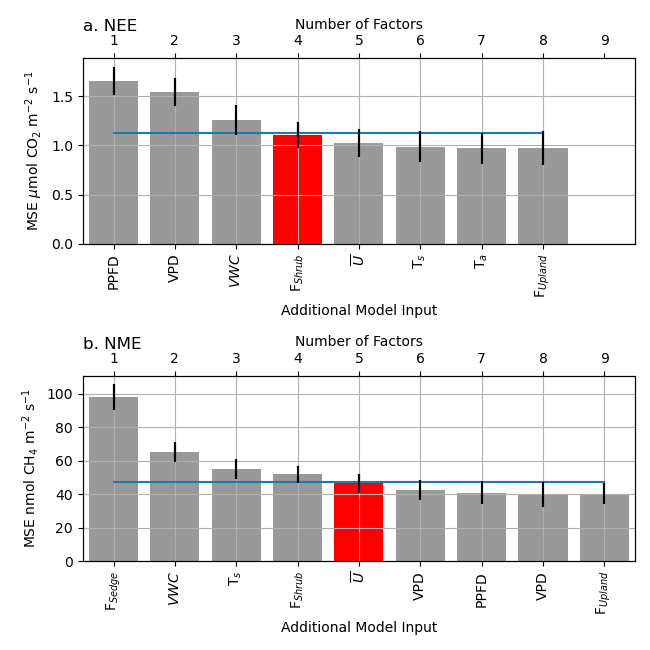

1 PPFD_Avg
2 PPFD_Avg+VPD
3 PPFD_Avg+VPD+VWC
4 PPFD_Avg+VPD+VWC+Shrub
5 PPFD_Avg+VPD+wind_speed+VWC+Out_of_Basin
6 PPFD_Avg+VPD+wind_speed+Temp+VWC+Out_of_Basin
7 PPFD_Avg+AirTC_Avg+VPD+wind_speed+Temp+VWC+Out_of_Basin
8 PPFD_Avg+AirTC_Avg+VPD+wind_speed+Temp+VWC+Out_of_Basin+Upland
1 Sedge
2 VWC+Sedge
3 Temp+VWC+Sedge
4 Temp+VWC+Sedge+Shrub
5 wind_speed+Temp+VWC+Sedge+Shrub
6 VPD+wind_speed+Temp+VWC+Sedge+Shrub
7 PPFD_Avg+wind_speed+Temp+VWC+Sedge+Shrub+Upland
8 PPFD_Avg+VPD+wind_speed+Temp+VWC+Sedge+Shrub+Upland
9 PPFD_Avg+VPD+wind_speed+Temp+VWC+Sedge+Shrub+Out_of_Basin+Upland
1.4920094325637052
1.7996572334362946


In [4]:

fco2 = ResultMap('fco2',Test='SE',Rule=1)
fch4 = ResultMap('fch4',Test='SE',Rule=1)
ER_interp = ResultMap('ER',Test='SE',Rule=1,AltPath='fco2')
fco2_fixed = ResultMap('fco2',Test='SE',Rule=1)
fch4_fixed = ResultMap('fch4',Test='SE',Rule=1)
ER_fixed = ResultMap('ER',Test='SE',Rule=1,AltPath='fco2')

fig,ax=plt.subplots(2,1,figsize=(6.5,6.5))
Performance(ax[0],'a. NEE',fco2,verbose = 0,lim=[0.5,9.5])
Performance(ax[1],'b. NME',fch4,verbose = 0,lim=[0.5,9.5])
ax[0].set_ylabel('MSE ${\mu}$mol CO$_{2}$ m$^{-2}$ s$^{-1}$')
ax[1].set_ylabel('MSE nmol CH$_{4}$ m$^{-2}$ s$^{-1}$')
plt.tight_layout()
plt.savefig('FigA1.png',dpi=300)
# print(fch4.Min)

print(1.645833333- 0.365124598/(24**.5)*stats.t.ppf(1-0.025,24))
print(1.645833333+ 0.365124598/(24**.5)*stats.t.ppf(1-0.025,24))


<IPython.core.display.Javascript object>


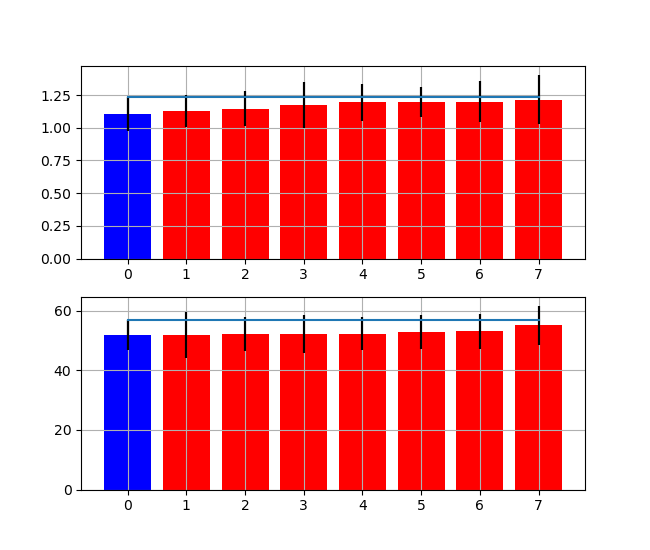

   index                          Model       MSE  Size  Number  HiddenNodes  \
0     24         PPFD_Avg+VPD+VWC+Shrub  1.104051     4       4           91   
1     26  PPFD_Avg+VPD+VWC+Out_of_Basin  1.128583     4       6           91   
2     27        PPFD_Avg+VPD+VWC+Upland  1.146359     4       7           91   
3     21    PPFD_Avg+VPD+wind_speed+VWC  1.173815     4       1           91   
4     25         PPFD_Avg+VPD+VWC+Grass  1.193858     4       5           91   
5     23         PPFD_Avg+VPD+VWC+Sedge  1.194884     4       3           91   
6     20     PPFD_Avg+AirTC_Avg+VPD+VWC  1.199053     4       0           91   
7     22          PPFD_Avg+VPD+Temp+VWC  1.214289     4       2           91   

         SE        r2  Performance    Thresh Model_Key      RMSE  T2  Select  
0  0.130592  0.901029            1  1.234643       4_4  1.050738   0       1  
1  0.125498  0.898830            1  1.254081       4_6  1.062348   0       1  
2  0.135435  0.897236            0  1.2817

In [5]:
fig,ax=plt.subplots(2,1,figsize=(6.5,5.5))
LevelPerformance(ax[0],'a. fco2',fco2,level=4)
LevelPerformance(ax[1],'b. fch4',fch4,level=4)
# print(T30)

In [15]:
T30 = fco2.RST.Master.copy()

T30['VWC'].loc[T30['VWC']<.5]=np.nan
T30['VWC']=T30['VWC'].interpolate()

T30['Rain_mm_Tot']=T30['Rain_mm_Tot'].fillna(0)*10
T30[['Sedge','Shrub','Grass','Upland','Temp','VWC']]=T30[['Sedge','Shrub','Grass','Upland','Temp','VWC']].interpolate()

# T30['VWC'] = .53
T30_Dark = T30.copy()
T30_Fixed = T30.copy()
T30_Dark['PPFD_Avg']=0#T30['PPFD_Avg'].min()
# T30_Dark['PPFD_Avg']=0#T30['PPFD_Avg'].min()

## For projecting to a given set of conditions
FPRatios = {'Sedge':1,
            'Sparse':.0,
            'Shrub':0,
            'Grass':.0,
            'Upland':0.0,
            'Out_of_Basin':0
}
# T30 = T30BU.copy()
for var in ['Sedge','Sparse','Shrub','Grass','Upland','Out_of_Basin']:
    T30_Fixed[var] = FPRatios[var]
T30_Dark_Fixed = T30_Fixed.copy()
T30_Dark_Fixed['PPFD_Avg']=0#T30['PPFD_Avg'].min()

T30 = Mapper(T30,fco2,'NEE_est',Fill = False)
print('NEE_est')

T30 = Mapper(T30,fch4,'NME_est',Fill = False)
print('NME_est')

T30 = Mapper(T30,ER_interp,'ER_interp_est',Fill = False,DarkTarget=T30_Dark)
print('ER_interp_est')

T30 = Mapper(T30,ER_fixed,'ER_fixed_est',Fill = False,DarkTarget=T30_Dark_Fixed)
print('ER_fixed_est')

T30 = Mapper(T30,fco2_fixed,'NEE_fixed_est',Fill = False,DarkTarget=T30_Fixed)
print('NEE_fixed_est')

T30 = Mapper(T30,fch4_fixed,'NME_fixed_est',Fill = False,DarkTarget=T30_Fixed)
print('NME_fixed_est')

T30BU = T30.copy()

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to

NEE_est


C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\sit

NME_est


C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\sit

ER_interp_est


C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\sit

ER_fixed_est


C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\sit

NEE_fixed_est


C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\sit

NME_fixed_est


In [16]:
# G-C.c=
T30 = T30BU.copy()
mult = {'fco2':(1e-6 * 12.0107 *1800),
        'ER':(1e-6 * 12.0107 *1800),
        'fch4':(1e-6 * 12.0107 *1800)}
T30['fch4']*=mult['fch4']
T30['fco2']*=mult['fco2']
T30['ER']*=mult['fco2']
for target,name in zip([fch4,fco2],['NME','NEE']):
    target.cols = []
    print(name)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')


for target,name in zip([fch4,fco2],['NME_est','NEE_est']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')


for target,name in zip([fch4_fixed,fco2_fixed,ER_interp,
                        ER_fixed],
                       ['NME_fixed_est','NEE_fixed_est','ER_interp_est',
                        'ER_fixed_est']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

NME
NEE
Done
Done
Done


In [17]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)

mult = {'fco2':(1e-6 * 12.0107 *1800),
        'ER':(1e-6 * 12.0107 *1800),
        'fch4':(1e-6 * 12.0107 *1800)}

Temp = T30.copy()
Estimates = []
CIs = []
SE = []
IntType = []
Scale = []
Samples = []
Fluxes = []
Type = []
Targets = {'NEE':fco2,
           'NME':fch4,
           'NEE_est':fco2,
           'ER_interp_est':ER_interp,
           'NME_est':fch4,
           'NEE_fixed_est':fco2_fixed,
           'ER_fixed_est':ER_fixed,
           'NME_fixed_est':fch4_fixed}
for Var in ['NEE','NEE_fixed_est',
            'ER_interp_est','ER_fixed_est','NME','NME_fixed_est']:
    target = Targets[Var]
    if Var == 'NEE' or Var == 'NME' or Var == 'ER':
        CIPI = 'CI'
        Fluxes.append(Var.split('_')[0])
        Type.append('EC Obs.')
        std = MI(Temp,target.cols)**.5#,Var,n=30)
        print((std/Temp.shape[0]**.5)*48*stats.t.ppf(1-.025,Temp[Var].count()))
        Int=(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())*48#*mult[target.target]

    else:
        Fluxes.append(Var.split('_')[0])
        CIPI = 'CI'
        Type.append('EC Obs.')
        std = (Temp[Var+'_Var_reg']).mean()**.5*mult[target.target]*48
        Int=((std)/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())*48#*mult[target.target
    SE.append(std)

    U = Temp[Var].sum()/(Temp.shape[0]/48)#*mult[target.target]
    Estimates.append(U)
    CIs.append(Int)
    
    if Var.split('_')[-1]=='fixed':
        Scale.append('Basin')
    elif len(Var.split('_'))>1:
        if Var.split('_')[1]=='fixed':#len(Var.split('_'))<2:
            Scale.append('Basin')
        else:
            Scale.append('Footprint')
    else:
        Scale.append('Footprint')
    
    Samples.append(Temp[Var].count())
    IntType.append(CIPI)
           
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}
# print(Data)
Res = pd.DataFrame(data = Data)
# print(Res)
Cres = pd.read_csv('Data/ScaledChamberFluxes.csv',
                   index_col=[0],delimiter = ',')
                   
# print(Cres)

All = Res.append(Cres).sort_values('Flux').reset_index(drop=True)
# Tem = (All.loc[All['Type'] == 'NN est.'])
Tem = (All.loc[((All['Type'] == 'NN est.')|(All['Type'] == 'EC Obs.'))])
# print(Tem)
CO2=(Tem.loc[Tem['Flux'] == 'NEE','Estimates']).values[0]
CH4=(Tem.loc[Tem['Flux'] == 'NME','Estimates']).values[0] #*28*1e-3

print(T30[['Upland','Sedge','Sparse','Grass','Shrub','Out_of_Basin']].mean())


# print(ER_fixed.Best)
print(T30['ER'].mean()*48)
print(T30['ER_interp_est'].mean()*48)
# print(T30['ER'].count())
print(T30['ER'].fillna(T30['ER_interp_est']).mean()*48)
print('Sedge max ',T30['Sedge'].max())

All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]


# print((T30['NEE']+T30['NME']*1e-3).mean()*24)
# print(T30)
## 100% Sedge
# ER 	EC Obs. 	Footprint 	2.190190 	0.367245 	0.945389
# ER 	EC Obs. 	Basin 	1.809964 	0.422877 	1.088600
# NEE 	EC Obs. 	Footprint 	-1.564621 	0.067907 	0.174810
# NEE 	EC Obs. 	Basin 	-1.863199 	0.389510 	1.002704
# NME 	EC Obs. 	Footprint 	8.672652 	0.174653 	0.449604
# NME 	EC Obs. 	Basin 	24.095103 	4.428764 	11.400840


## 100% Srhub
# ER 	EC Obs. 	Footprint 	2.190190 	0.367245 	0.945389
# ER 	EC Obs. 	Basin 	2.429363 	0.622009 	1.601219
# NEE 	EC Obs. 	Footprint 	-1.564621 	0.067907 	0.174810
# NEE 	EC Obs. 	Basin 	-0.930174 	0.563725 	1.451181
# NME 	EC Obs. 	Footprint 	8.672652 	0.174653 	0.449604
# NME 	EC Obs. 	Basin 	13.688531 	2.920729 	7.518748

0.1748102423886344
0.44960431913861776
Upland          0.062524
Sedge           0.108134
Sparse          0.022291
Grass           0.375453
Shrub           0.365338
Out_of_Basin    0.122589
dtype: float64
2.627049863486774
2.190189778804779
2.206393904997518
Sedge max  0.5558567172950846


,Flux,Type,Scale,Estimates,SE,95% CI/PI
0,ER,EC Obs.,Footprint,2.190190,0.367245,0.945389
1,ER,EC Obs.,Basin,1.809964,0.422877,1.088600
2,ER,Chamber Obs.,Footprint,4.367188,0.423816,0.844234
3,ER,Chamber Obs.,Basin,4.008449,0.421306,0.840870
4,NEE,EC Obs.,Footprint,-1.564621,0.067907,0.174810
5,NEE,EC Obs.,Basin,-1.863199,0.389510,1.002704
6,NME,EC Obs.,Footprint,8.672652,0.174653,0.449604
7,NME,EC Obs.,Basin,24.095103,4.428764,11.400840
8,NME,Chamber Obs.,Footprint,13.630093,4.000197,7.968323
9,NME,Chamber Obs.,Basin,14.968051,4.331294,8.644676


In [18]:


T30['GPP'] = -1*T30['NEE_est']+T30['ER_interp_est']
T30['GPP_fixed'] = -1*T30['NEE_fixed_est']+T30['ER_fixed_est']


T30 = T30.loc[((T30.index>'2016-07-10 23:30:00') & (T30.index<'2016-08-07 00:00:00'))]
HafHourly = T30.resample('D').mean()
# v='NEE'

HafHourly['Rain_mm_Tot'] = T30['Rain_mm_Tot'].resample('D').sum()
HafHourlys = T30.resample('D').std()
for target,v in zip([fco2,fch4],['NEE','NME']):
    for day in HafHourly.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
        HafHourly.loc[HafHourly.index==day,v+'_Var']=MI(Samp,target.cols,JustBetween=True)*48#/(Samp.shape[0]**.5)*stats.t.ppf(1-.025,Samp.shape[0])

for target,v in zip([ER_interp,fco2,fch4],['ER_interp_est','NEE_est','NME_est']):
    for day in HafHourly.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
        HafHourly.loc[HafHourly.index==day,v+'_Var']=(Samp[v+'_Var_reg']).mean()**.5*mult[target.target]#*48
    

Daily = T30.resample('D').sum()
Daily['ER_interp_est_CI'] = (HafHourly['ER_interp_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NEE_CI'] = (HafHourly['NEE_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NEE_est_CI'] = (HafHourly['NEE_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NME_CI'] = (HafHourly['NME_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NME_est_CI'] = (HafHourly['NME_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#

Weekly = Daily[['NEE','NME','ER_interp_est','GPP']].resample('W').mean()
# print(Weekly['NME']*16.01/12.01)
# print(Weekly[['NEE','ER_interp_est','GPP']])


# print(T30['DOY'].min(),T30['DOY'].max())
# print(T30['NEE'].sum())#/(220-194))
# print(T30['fco2'].sum())#/(220-194))

9.530729943064173
-1.368557867628356


<IPython.core.display.Javascript object>


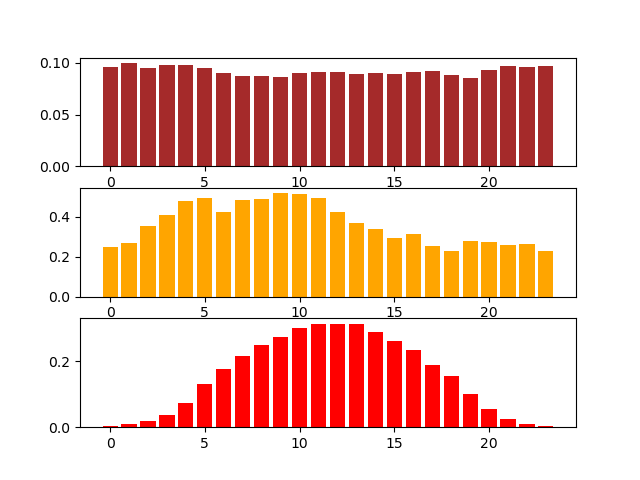

14.467896136373318
0.22122660042642064
datetime
0      4.457317
1      4.556559
2      3.818832
3      3.026973
4      1.460587
5     -0.917144
6     -3.488280
7     -6.497337
8     -7.884764
9     -8.559730
10    -9.994031
11   -10.283344
12   -10.154562
13   -10.401455
14    -9.610146
15    -7.914832
16    -6.689509
17    -4.785400
18    -3.438341
19    -0.893732
20     1.101565
21     3.279039
22     4.046219
23     4.727780
Name: NEE, dtype: float64


In [19]:

print(T30['AirTC_Avg'].mean())
print(Daily['fco2'].mean())


Hr = T30.groupby(T30.index.hour).mean()*2
fig,ax = plt.subplots(3,1)
ax[0].bar(Hr.index,Hr['ER_interp_est'],color='brown')
ax[1].bar(Hr.index,Hr['NME'],color='orange')
ax[2].bar(Hr.index,Hr['GPP'],color='red')

print(Hr['GPP'].max()/mult['fco2'])
print(Hr['GPP'].min()/mult['fco2'])
print(Hr['NEE']/mult['fco2'])

<IPython.core.display.Javascript object>


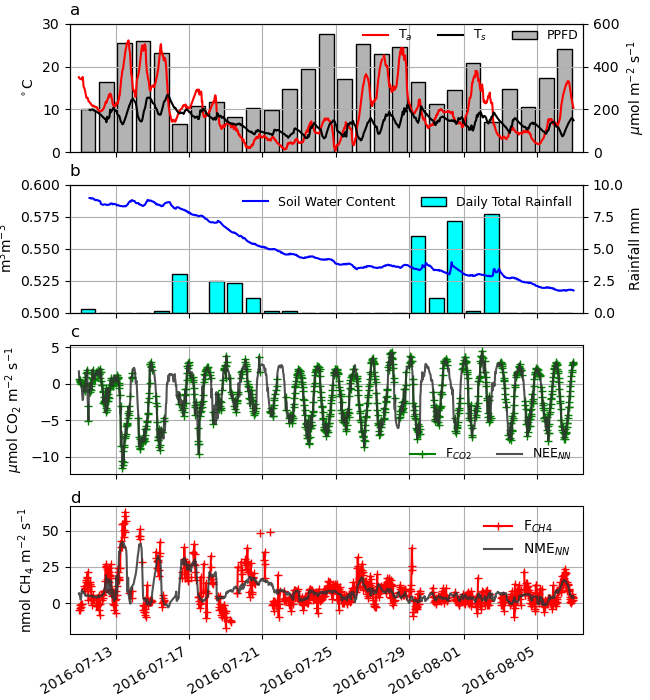

0.5895 0.51725


In [20]:
fig,ax = plt.subplots(4,1,figsize = (6.5,7),sharex=True)
ax[0].plot(T30['AirTC_Avg'],color='red',label = 'T$_a$')
ax[0].plot(T30['Temp'],color='black',label = 'T$_s$')
ax[0].bar(T30.index,T30['PPFD_Avg']*np.nan,facecolor=[.7,.7,.7],edgecolor='black',label = 'PPFD')
ax[0].set_ylim(0,30)
yax2 = ax[0].twinx()
yax2.bar(HafHourly.index+datetime.timedelta(hours=12),HafHourly['PPFD_Avg'],
         facecolor=[.7,.7,.7],edgecolor='black',label = 'PPFD')
yax2.set_ylim(0,600)

ax[0].grid()
ax[0].set_zorder(ax[0].get_zorder()+1)
ax[0].patch.set_visible(False)

yax2.set_ylabel('${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[0].set_ylabel('$^\circ$C')
ax[0].legend(ncol = 3,fontsize=9,loc=0,facecolor='None',edgecolor='None',bbox_to_anchor=(.55,.76))
ax[0].set_title('a',loc='left')

yax2 = ax[1].twinx()
yax2.bar(Daily.index+datetime.timedelta(hours=12),Daily['Rain_mm_Tot'],
         facecolor='cyan',edgecolor='black',label = 'Daily Total Rainfall')
# ax[1].bar(Daily.index,Daily['Rain_mm_Tot']*np.nan,label = 'Daily Total Rainfall')
yax2.set_ylim(0,10)

ax[1].plot(T30['VWC'],color='blue',label = 'Soil Water Content')
# ax[1].plot(fco2.RST.Master['VWC'],color='orange',label = 'Soil Water Content')
ax[1].bar(Daily.index,Daily['Rain_mm_Tot']*np.nan,facecolor='cyan',edgecolor='black',label = 'Daily Total Rainfall')
ax[1].set_ylim(.50,.6)
ax[1].grid()
ax[1].set_zorder(ax[1].get_zorder()+1)
ax[1].patch.set_visible(False)
yax2.set_ylabel('Rainfall mm')
ax[1].set_ylabel('m$^{3}$m$^{-3}$')
ax[1].set_title('b',loc='left')
ax[1].legend(ncol=2,fontsize=9,facecolor='None',edgecolor='None')

ax[0].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[1].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])

gap=[.2,.2,.2,.85]
ax[2].plot(T30.index,T30['fco2']/mult['fco2'],label='F$_{CO2}$',color='g',marker='+')
ax[2].plot(T30.index,T30['NEE']/mult['fco2'],label='NEE$_{NN}$',color=gap)
# [0,1,0,.75]
ax[2].grid()
ax[2].set_title('c',loc='left')
ax[2].set_ylabel(r'${\mu}$mol CO$_2$ m$^{-2}$ s$^{-1}$')#${\mu}$mol
ax[2].legend(fontsize=9,facecolor='None',edgecolor='None',ncol=2,loc=0)

ax[2].set_xticklabels([])


ax[3].plot(T30.index,T30['fch4']/mult['fch4'],label='F$_{CH4}$',color='r',marker='+')
ax[3].plot(T30.index,T30['NME_est']/mult['fch4'],label='NME$_{NN}$',color=gap)
ax[3].grid()
ax[3].set_title('d',loc='left',pad = -.3)
ax[3].set_ylabel(r'nmol CH$_4$ m$^{-2}$ s$^{-1}$')#nmol

ax[2].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[3].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
# ax[3].scatter(Dates['Date'],Dates['Value']*0,marker = '*',label = 'Chamber Observations')
ax[3].legend(facecolor='None',edgecolor='None')

fig.autofmt_xdate()
plt.tight_layout(pad=0.25)

# plt.savefig('Fig3.png',dpi=300)

plt.savefig('Fig2.png',dpi=300)
print(T30['VWC'].max(),T30['VWC'].min())

In [21]:
print(T30.resample('W').mean()['NEE']*48)
print(T30['NEE'].mean()*48)
print((1.87+1.52+1.49)/3)
print(1.7 * mult['fco2']*48)
# print(4.22/107*12,
#       5.89/108*12)

datetime
2016-07-17   -1.872631
2016-07-24   -1.245486
2016-07-31   -1.520919
2016-08-07   -1.498815
Freq: W-SUN, Name: NEE, dtype: float64
-1.5357833022768892
1.6266666666666667
1.7641316159999998


# Nighttime ER estimation methods

(95, 7)
1.5741693899593865 2.851352643298046


<IPython.core.display.Javascript object>


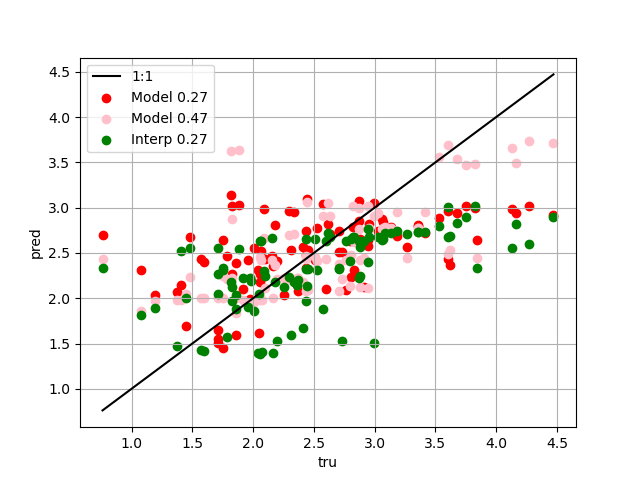

Mean ER:
ER               0.001178
ER_interp_est    0.001000
ER2              0.050093
ER3              0.001374
dtype: float64

R2 Score:
ER_interp_est:  0.2679702857491175 ER2:  0.2673109018833115 ER3:  0.47468814561052086

MSE:
ER_interp_est:  0.642534528266777 ER2:  0.6428238481727505 ER3:  0.5443029852159965
95
fco2             2.519671
ER_interp_est    2.304427
dtype: float64 2.52129560845136
0.2679702857491175 2
0.47480748837157366 1.1699394513174607e-14
0.35045025369243515 2.6460153421425706e-10
ER_interp_est    2.212328
ER3              3.011555
dtype: float64


In [24]:
import scipy
## R2 = .58 for ER - Modeled @ PPFD_Avg<10

def P_func(PPFD,MQY,PM):
    cv =.7
    return((MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5)/(2*cv))
def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_func2(T,Q10,R10):
    return(R10*Q10**((T-10)/10))

Dark = T30.loc[T30['PPFD_Avg']<10,['Temp','fco2','ER_interp_est',
                                   'ER','AirTC_Avg','VPD','VWC']].dropna()
Dark['fco2']/=mult['fco2']
Dark['ER_interp_est']/=mult['fco2']
print(Dark.shape)
popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 45.9262144,0.5875255,2.7508822))
popt_r2, pcov2 = curve_fit(R_func2, Dark['AirTC_Avg'], Dark['fco2'])#,p0=( 4.59262144,0.5875255,0.27508822))
print(popt_r2[0],popt_r2[1])
plt.figure()
plt.scatter(Dark['fco2'],R_func(Dark['Temp'],*popt_r),c='red',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),2)))
plt.scatter(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2),c='pink',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)),2))
           )
Dark['ER3'] = (R_func2(Dark['AirTC_Avg'],*popt_r2))
plt.scatter(Dark['fco2'],Dark['ER_interp_est'],c='green',
            label='Interp '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_interp_est']),2)))
plt.plot([Dark['fco2'].min(),Dark['fco2'].max()],[Dark['fco2'].min(),Dark['fco2'].max()],
         label='1:1',color='black')
plt.ylabel('pred')
plt.xlabel('tru')
plt.legend()


# plt.xlim(0,1)
# plt.ylim(0,1)
plt.grid()
T30['ER2'] = R_func(T30['Temp'],*popt_r)
T30['ER3'] = R_func2(T30['AirTC_Avg'],*popt_r2)*mult['fco2']


P = T30[T30['PPFD_Avg']>=10]
P = P[['fco2','ER2','ER3','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER2']),p0=(.01,10))
popt_p3, pcov3 = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER3']),p0=(.01,10))
# T30['GPP2'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
T30['GPP2'] = P_func(T30['PPFD_Avg'],*popt_p)
T30['GPP3'] = P_func(T30['PPFD_Avg'],*popt_p3)
T30['NEE2'] = T30['ER2']-T30['GPP2']
T30['NEE3'] = T30['ER3']-T30['GPP3']


Temp = T30.loc[np.isnan(T30['fco2'])==False]
print('Mean ER:')
print(Temp[['ER','ER_interp_est','ER2','ER3']].mean()*mult['fco2'])
# print(Dark['fco2'].mean())
print()
print('R2 Score:')
print('ER_interp_est: ',metrics.r2_score(Dark['fco2'],Dark['ER_interp_est']),
     'ER2: ',metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),
     'ER3: ',metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)))
print()
print('MSE:')
print('ER_interp_est: ',metrics.mean_squared_error(Dark['fco2'],Dark['ER_interp_est'])**.5,
     'ER2: ',metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5,
     'ER3: ',metrics.mean_squared_error(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2))**.5)
print(Dark['fco2'].count())
print(Dark[['fco2','ER_interp_est']].mean(),R_func2(Dark['AirTC_Avg'],*popt_r2).mean())

print(metrics.r2_score(Dark['fco2'],Dark['ER_interp_est']),2)


# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Dark['fco2'],Dark['ER_interp_est'])
# print(r_value**2, p_value)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Dark['fco2'],Dark['ER3'])
print(r_value**2, p_value)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Dark['fco2'],Dark['ER_interp_est'])
print(r_value**2, p_value)


print(T30[['ER_interp_est','ER3']].mean()*48)

# GLM and Random Forest Comparrisons

<IPython.core.display.Javascript object>


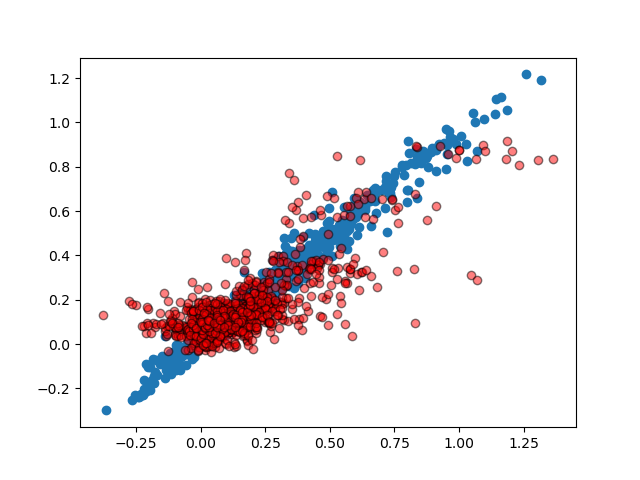

0.0013651988076734943
0.9759192645382868
9.061919812721323

0.020436805710670355
0.619076710657228
      feature  importance
2         VWC    0.426186
3       Sedge    0.225597
1        Temp    0.144992
0  wind_speed    0.110109
4       Shrub    0.093116


In [28]:

plt.figure()
n_estimators=400
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=n_estimators,
#                                min_samples_leaf = 10,
                               random_state=1,
                              )
Inputs = fch4.params['Inputs']
forest.fit(fch4.RST.Data[Inputs],fch4.RST.Data[fch4.params['target']])
y_pred = forest.predict(fch4.RST.Data[Inputs])
fch4.RST.Data['y_pred3']=y_pred
plt.scatter(fch4.RST.Data['fch4']/48,fch4.RST.Data['y_pred3']/48)
plt.scatter(T30['fch4'],T30['NME_est'],c='red',edgecolor='black',alpha=.5)
print(metrics.mean_squared_error(y_pred/48,fch4.RST.Data[fch4.params['target']]/48))
print(metrics.r2_score(fch4.RST.Data[fch4.params['target']],y_pred))
print(y_pred.mean())
print()
Temp = T30[['fch4','NME_est']].dropna()
print(metrics.mean_squared_error(Temp['NME_est'],Temp['fch4']))
print(metrics.r2_score(Temp['fch4'],Temp['NME_est']))

fi = pd.DataFrame({'feature': list(Inputs),
                   'importance': forest.feature_importances_}).\
                    sort_values('importance', ascending = False)
print(fi)


<IPython.core.display.Javascript object>


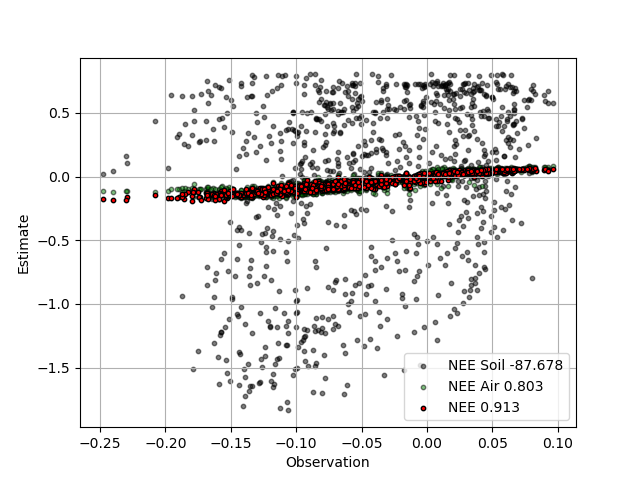

<IPython.core.display.Javascript object>


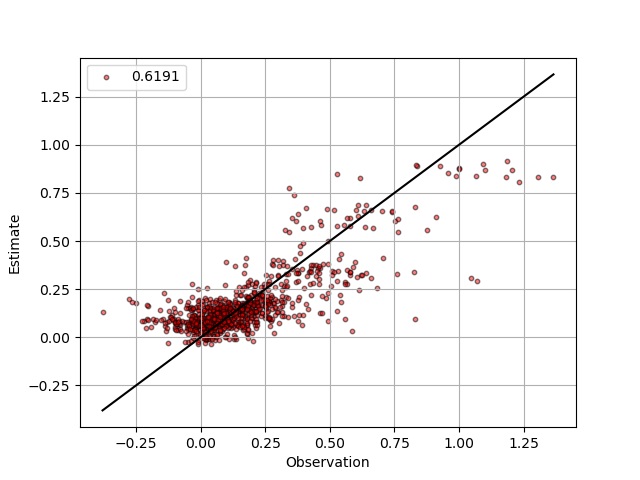

-1.4028237677754043
0.020436805710670355


In [29]:
plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NEE2','NEE3','NEE_est','fco2']].dropna()
LM = T30['fco2'].min(),T30['fco2'].max()
# plt.plot(LM,LM,color='black')
plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
           label='NEE Soil '+str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),3)))
plt.scatter(T30['fco2'],T30['NEE3'],c='green',edgecolor='black',alpha=.5,s=10,
           label='NEE Air '+str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE3']),3)))
plt.scatter(Temp['fco2'],Temp['NEE_est'],c='red',edgecolor='black',alpha=1,s=10,
           label='NEE '+str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
# plt.ylim(-1.9,1)
# plt.xlim(-1.9,1)

plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NME_est','fch4']].dropna()
# print(T30[['NME_est','fch4']])
LM = T30['fch4'].min(),T30['fch4'].max()
plt.plot(LM,LM,color='black')
plt.scatter(T30['fch4'],T30['NME_est'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fch4'],Temp['NME_est']),4)))


plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
# plt.ylim(-1.9,1)
# plt.xlim(-1.9,1)
print(T30['NEE3'].mean()*48)
print(metrics.mean_squared_error(Temp['fch4'],Temp['NME_est']))

# ER estimates with chamber and flux derived Q10 and R10 values

         Q10   CIQ   R10   CIR  Q10_uv  CIQ_uv  R10_uv  CIR_uv
Class                                                         
Grass   1.53  0.20  3.68  0.33    1.45    0.34    2.62    0.46
Sedge   2.04  0.19  3.56  0.35    1.05    0.47    1.98    0.54
Shrub   1.57  0.11  2.16  0.10    1.42    0.22    1.55    0.23
Sparse  0.95  0.12  1.90  0.18     NaN     NaN     NaN     NaN
Upland  1.72  0.22  2.78  0.32    1.35    0.30    1.58    0.27
Water   0.00  0.00  0.00  0.00    0.00    0.00    0.00    0.00

FP Weighted RE:
3.6268173958979597
0.09404387091470387
Q10 RE:
0.06510759621363402
0.0010630284878250964
Basin Est
3.3194837143964757


<IPython.core.display.Javascript object>


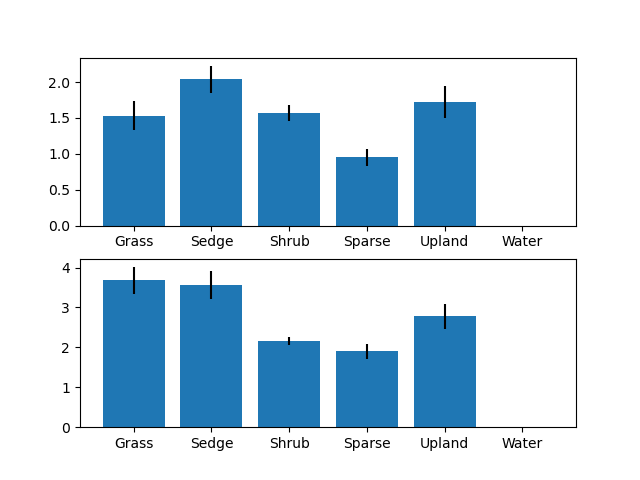

         Q10   R10
Class             
Grass   1.53  3.68
Sedge   2.04  3.56
Shrub   1.57  2.16
Sparse  0.95  1.90
Upland  1.72  2.78
Water   0.00  0.00
1.5741693899593865 131.88946537939069


<IPython.core.display.Javascript object>


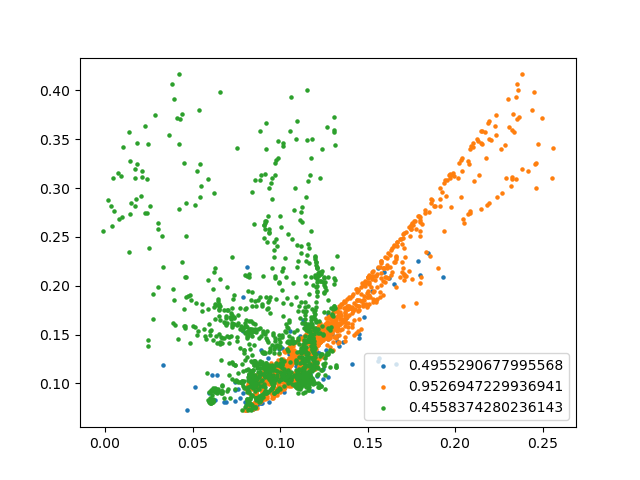

0.45583742802361443 1.5722815910081073e-13
0.9526947229936938 2.0175905515338683e-61
0.0017051835777167402


In [30]:

FPRatios = {'Sedge':.109629,
            'Sparse':.022089,
            'Shrub':.370768,
            'Grass':.368608,
            'Upland':.062327,
            'Out_of_Basin':0
}

Index = ['Tundra',
'Peat Plateau',
'Low Willow',
'Dense Willow',
'Tall Willow',
'Cotton Grass',
'Wet Sedge_1' ,
'Wet Sedge_2' ,
'Grass',
'Water',
'Bare Ground']

Class = ['Upland','Upland','Shrub','Shrub','Shrub','Grass','Sedge','Sedge','Grass','Water','Sparse']

Columns = ['Q10','CIQ','R10','CIR','Q10_uv','CIQ_uv','R10_uv','CIR_uv']

Data =[[1.72, (0.23), 5.35, (0.74), 1.56, (0.30), 1.58, (0.27)],
[2.04, (0.22), 2.78, (0.32), 1.35, (0.33), 1.79, (0.34)],
[1.93, (0.17), 3.64, (0.33), 1.74, (0.27), 2.46, (0.35)],
[1.57, (0.16), 2.40, (0.21), 1.42, (0.22), 2.21, (0.26)],
[1.67, (0.11), 2.16, (0.10), 1.78, (0.36), 1.55, (0.23)],
[1.86, (0.20), 3.97, (0.33), 1.45, (0.37), 2.62, (0.46)],
[2.23, (0.19), 3.85, (0.35), 1.38, (0.48), 1.98, (0.54)],
[2.04, (0.23), 3.56, (0.46), 1.05, (0.47), 2.36, (0.74)],
[1.53, (0.21), 3.68, (0.50), 1.45, (0.34), 2.97, (0.63)],
[0, (0), 0, (0), 0, (0), 0, (0)],
[0.95, (0.12), 1.90, (0.18)]]
All={
'Upland' : [1.852521311077543, 4.1146136475207244],
'Sedge' : [2.1148600372644646, 3.854903571300543],
'Grass' : [1.570166164940777, 4.042483922973848],
'Shrub' : [1.8274454867131564, 2.744387486442054],
'Sparse' : [0.9713475903755051, 1.8995217596808844],
'Water': [1,0]
}

# Sedge 2.1148600372644646 3.854903571300543
# Sedge 2.1148600372644646 3.854903571300543
# Shrub 1.8274454867131564 2.744387486442054
# Shrub 1.8274454867131564 2.744387486442054
# Grass 1.570166164940777 4.042483922973848
# Grass 1.570166164940777 4.042483922973848
# Sparse 0.9713475903755051 1.8995217596808844
# Sparse 0.9713475903755051 1.8995217596808844
# Upland 1.852521311077543 4.1146136475207244
# Upland 1.852521311077543 4.1146136475207244


Fixes = pd.DataFrame(data = Data, index = Index, columns = Columns)
Fixes['Class']=Class
Classes=Fixes.groupby('Class').min()
# Classes['Water']
print(Classes)
# print(popt_r2[0],popt_r2[1]/mult['fco2'])
# Temps = np.arange(0,25)
# plt.figure(figsize=(10,10))
B=[]


FPRatios = {'Sedge':0.122590,
            'Sparse':0.083902,
            'Shrub':0.482874,
            'Grass':0.279263,
            'Water':0.031371,
            'Upland':0.0,
            'Out_of_Basin':0.0
}
i=0
print()
for F in Classes.index.unique():
#     print(Classes.loc[Classes.index==F,['Q10','R10']])
#     V = Classes.loc[Classes.index==F,['Q10','R10']].values[0]
#     plt.plot(V[1]*V[0]**((T30['AirTC_Avg'].values-10)/10),label = F,linewidth = 2)
#     print(F,np.nanmean(V[1]*V[0]**((T30['AirTC_Avg'].values-10)/10)))
    B.append(np.nanmean(All[F][1]*All[F][0]**((T30['AirTC_Avg'].values-10)/10))*(FPRatios[F]))
    if i == 0:
        T30['RE'] = (All[F][1]*All[F][0]**((T30['AirTC_Avg'].values-10)/10)*(T30[F]/T30[Classes.index.unique()].sum(axis=1)))
        i+=1
    else:
        T30['RE'] += (All[F][1]*All[F][0]**((T30['AirTC_Avg'].values-10)/10)*(T30[F]/T30[Classes.index.unique()].sum(axis=1)))
print('FP Weighted RE:')
print(T30['RE'].mean())
print(T30['RE'].std()/(T30['RE'].count()**.5)*stats.t.ppf(1-.025,T30['RE'].count()))

print('Q10 RE:')
print(T30['ER3'].mean()*mult['fco2']*48)
print(T30['ER3'].std()/(T30['ER3'].count()**.5)*stats.t.ppf(1-.025,T30['ER3'].count())*mult['fco2']*48)

# plt.plot((0.06164413*1.57416937 **((T30['AirTC_Avg'].values-10)/10))/mult['fco2'],linewidth = 5,label='EC')
# plt.legend(fontsize = 15)

T30['RE_D']=0.06164413*1.57416937 **((T30['AirTC_Avg'].values-10)/10)#*mult['fco2']*2

print('Basin Est')
print(np.sum(np.array(B))*mult['fco2']*48)
# print()
# print(np.nanmean(0.06164413*1.57416937 **((T30['AirTC_Avg'].values-10)/10))*48)
    
fig,ax=plt.subplots(2,1)
# Classes['Q10'].plot.bar()
ax[0].bar(Classes.index,Classes['Q10'],yerr=Classes['CIQ'])
ax[1].bar(Classes.index,Classes['R10'],yerr=Classes['CIR'])
# Classes['R10']*=mult['fco2']
print(Classes[['Q10','R10']])
print(popt_r2[0],popt_r2[1]/mult['fco2'])


Temp = T30[['ER','ER3','RE','RE_D','ER_interp_est']].dropna()
# Temp['RE']*=2
plt.figure()
plt.scatter(T30['ER']*2,T30['RE']/24,
            s=5,label=np.corrcoef(Temp['RE']/24,Temp['ER']*2)[0,1]**2)
plt.scatter(T30['ER3']*2,T30['RE']/24,
            s=5,label=np.corrcoef(Temp['RE']/24,Temp['ER3']*2)[0,1]**2)

import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Temp['RE']/24,Temp['ER_interp_est']*2)
print(r_value**2,p_value)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Temp['RE']/24,Temp['ER3']*2)
print(r_value**2,p_value)

plt.scatter(T30['ER_interp_est']*2,T30['RE']/24,marker='o',
            s=5,label=np.corrcoef(Temp['RE']/24,Temp['ER_interp_est']*2)[0,1]**2)

print(metrics.mean_squared_error(Temp['RE']/24,Temp['ER_interp_est']*2))
plt.legend()


<IPython.core.display.Javascript object>


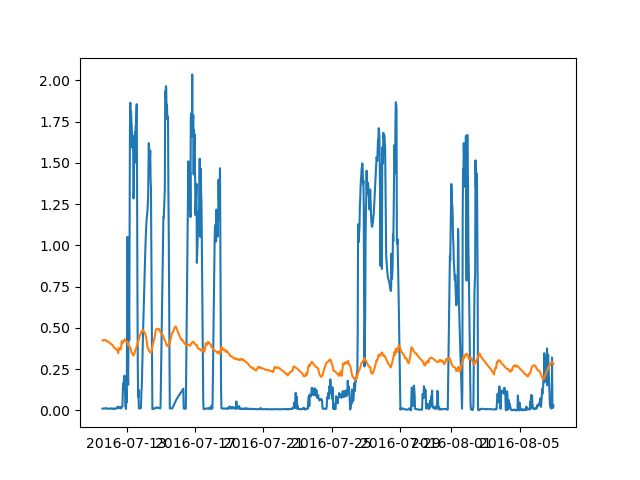

0

Upland  -0.0653468062772544
Shrub  0.19724035477060076
Grass  0.1637734667605043
Sparse  0.00034122785144472786
Sedge  15.305897932771572
Mean
8.095239986685302
0.7134216407597372


<IPython.core.display.Javascript object>


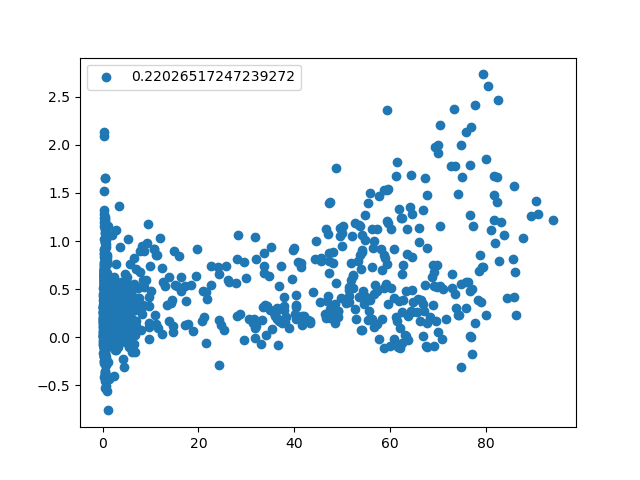

0.22026517247239266 1.9070797889907034e-70

0.33719650543518886 3.331171829102756e-115

1

Upland  0.0
Shrub  0.24528459816914383
Grass  0.12283923230648625
Sparse  0.008669052067660388
Sedge  14.026065748768717
Mean
7.473099491845873
0.09498362642922918
0.010825662745524446 0.0002061065554472251

0.016646882374671643 4.043825227495083e-06



In [32]:





T30_BU = T30.copy()


FPRatios = {'Sedge':0.122590,
            'Sparse':0.083902,
            'Shrub':0.482874,
            'Grass':0.279263,
            'Water':.03131,
            'Upland':0.0,
            'Out_of_Basin':0.0
}
fig,ax=plt.subplots()
# ax.plot([1,2,3])
for i in range(2):
    print(i)
    for F in ['Sedge','Shrub','Sparse','Grass','Upland','Out_of_Basin']:
        if i == 1:
            T30[F] = FPRatios[F]#*0
        else:
            T30[F] = T30[F].interpolate()/T30[Classes.index.unique()].sum(axis=1)


    F = 'Sedge'
    # VCW = 0
    # Sedge
    Temp =  9.399268
    VWC =  349.931616
    Const =   -145.637484
    # dtype: float64
    T30[F+'CH4'] = ((T30['VWC']*VWC+T30['Temp']*Temp+Const)*T30[F])

    F = 'Water'
    T30[F+'CH4'] = ((T30['VWC']*VWC+T30['Temp']*Temp+Const)*T30[F])

    F = 'Shrub'
   
    # Shrub
    Temp =-0.081100
    VWC =  25.557529
    Const =   -12.941010
    # dtype AirTC_Avg=     0.012461
#     VWC=       19.436749
#     Const =      -10.252190

    T30[F+'CH4'] = ((T30['VWC']*VWC+T30['Temp']*Temp+Const)*T30[F])

    F = 'Grass'
    
    
    # Grass
    Temp =0.077228
    VWC = -8.296785
    Const =    4.438190
    # dtype: float64
    T30[F+'CH4'] = ((T30['VWC']*VWC+T30['Temp']*Temp+Const)*T30[F])

    F = 'Upland'
    
    
    # Upland
    Temp = 0.047680
    VWC = -17.711548
    Const =     8.387708
    # dtype: float64
    T30[F+'CH4'] = ((T30['VWC']*VWC+T30['Temp']*Temp+Const)*T30[F])


    F = 'Sparse'
    
#     Sparse
    Temp =0.199842
    VWC =  4.255964
    Const =   -3.677235
    T30[F+'CH4'] = ((T30['VWC']*VWC+T30['Temp']*Temp+Const)*T30[F])


#     plt.figure(figsize=(6,3))
    T30['CH4Sum']=0
    T30['Sum']=0
    print()
    for F in ['Upland','Shrub','Grass','Sparse','Sedge']:
        T30['CH4Sum']+=T30[F+'CH4']
        T30['Sum']+=T30[F]
#         plt.plot(T30[F+'CH4'],label = F)
        print(F+' ',T30[F+'CH4'].mean())
#         plt.plot(T30[F],label=F)
    # plt.yscale('symlog')
#     plt.legend()
    print('Mean')
    print(T30['CH4Sum'].mean()*mult['fch4']*24)
    ax.plot(T30['CH4Sum']*mult['fch4'])
    print(T30['CH4Sum'].std()/(T30['CH4Sum'].count()**.5)*
          stats.t.ppf(1-0.025,T30['CH4Sum'].count())*mult['fch4']*24)

    # print(T30['Sum'].mean())
    Temp = T30[['CH4Sum','NME_est','NME']].dropna()
    if i == 0:
        plt.figure()
    #     Temp['NME']*=2
        plt.scatter(T30['CH4Sum'],T30['NME']*2,label=np.corrcoef(Temp['CH4Sum'],Temp['NME'])[0,1]**2)
        plt.legend()


    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Temp['CH4Sum'],Temp['NME'])
    print(r_value**2,p_value)
#     print(np.corrcoef(Temp['CH4Sum'],Temp['NME'])[0,1]**2)
    print()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Temp['CH4Sum'],Temp['NME_est'])
    print(r_value**2,p_value)
    print()

T30 = T30_BU.copy()
# print(T30)

In [33]:
Temp = T30[['Sedge','Shrub','wind_speed','Out_of_Basin','AirTC_Avg','fch4','VWC','Temp']].dropna()
Temp['Const']=1
import statsmodels.api as sm
print(stats.pearsonr(Temp['VWC'],Temp['Temp']))
# print(stats.pearsonr(Temp['Temp'],Temp['fch4']))

model = sm.OLS(Temp['fch4'],Temp[['Sedge','VWC','Temp','Shrub','Const']])
Res = results = model.fit()
P = Res.params
# Test = T30['Sedge']*P[0]+T30['VWC']*P[1]+T30['Temp']*P[2] + P[3]
# print(Test.mean()*48)
print(Res.summary())

(0.5410402623140784, 1.1498760953291533e-64)
                            OLS Regression Results                            
Dep. Variable:                   fch4   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     78.46
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           1.80e-56
Time:                        14:14:58   Log-Likelihood:                 167.33
No. Observations:                 835   AIC:                            -324.7
Df Residuals:                     830   BIC:                            -301.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Sedge  

In [34]:
def Plot(ax,Label,Data,regressor,color,target,Interval=None,linestyle='-',mult=1,alpha=None): 
    rgba = color.copy()
    if alpha is None:
        rgba[3]=.05
    else:
        rgba.append(alpha)
    Data = Data.sort_values(regressor)#.reset_index()
    try:
        Data['True']*=1
    except:
        Data['True']=0
        pass
    ax.plot(Data[regressor],Data[target]*mult,
            label= Label,
            linestyle=linestyle,
            linewidth=1.5,
            color = color)
    if Interval != None:
        ax.fill_between(Data[regressor],
                    mult*(Data[target]-Data[Interval]), 
                    mult*(Data[target]+Data[Interval]),
                    facecolor = rgba,
                    edgecolor = color,
                    linestyle=':',
                    linewidth=1,
                   )

In [35]:
## from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def MapJobs(target,Range,N,Mask={},map_range=None):
    target.Project(Projector = None,Model = None)
    columns=[Range]
    l = 1
    for key in Mask.keys():
        columns.append(key)  
        l+=1
    for v in target.params['Inputs']:
        if v not in columns:
            columns.append(v)
    try:
        scaler = StandardScaler()
        scaler.fit(target.RST.Data[columns[l:]])
        Temp = scaler.transform(target.RST.Data[columns[l:]])
        Temp = pd.DataFrame(data = Temp,columns = columns[l:])
        kmeans = KMeans(n_clusters=N, random_state=0).fit(Temp)
        Q = scaler.inverse_transform(kmeans.cluster_centers_)
    except:
        Q = []
        for col in columns[1:]:
            Q.append(Mask[col])
        Q=np.asanyarray(Q).T
        pass
    columns.append('target')
    def Make(Data,columns,map_range,values,C=20,Mask=None,i=0):
        ranges = [np.linspace(map_range[0],map_range[1],C)]
        for key in Mask.keys():
            ranges.append(np.ones(C)*Mask[key])
        for v in values:
            ranges.append(np.ones(C)*v)
        ranges.append(np.ones(C)*0)
        data = {}
        for (col,ran) in zip(columns,ranges):
            data[col]=ran
        data['key']=i
        
        return(pd.DataFrame(data = data))
    tarList=[]
    if map_range is None:
        map_range = [target.RST.Data[columns[0]].min(),target.RST.Data[columns[0]].max()]
    if len(Q) == 0:
        Data = Make(target.RST.Data,columns,
                    map_range=map_range,
                    values=[],Mask={key:item[i] for key, item in Mask.items()})
    for i,quantile in enumerate(Q):
        values = []
        for q in quantile:
            values.append(q)
        if i == 0:
            Data = Make(target.RST.Data,columns,
                    map_range=map_range,values=values,C=30,
                    Mask={key:item[i] for key, item in Mask.items()})
        else:
            Data = Data.append(Make(target.RST.Data,columns,
                    map_range=map_range,values=values,C=30,
                    Mask={key:item[i] for key, item in Mask.items()},i=i))
    target.RST.Data=Data
    target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
    target.Map()
    tarList.append(target.Data_Map)  
    return(tarList,Q,columns[1:-1],Data,target,Range)

In [36]:
import itertools
target = fco2#_interp
List = []
n = 25
Vars = []
print(target.Best['Model'])
for var in target.Best['Model'].values[0].split('+'):
    Vars.append(var)
#     List.append([T30[var].quantile(q/100) for q in range(0,101,10)])
    List.append(np.linspace(T30[var].min(),T30[var].max(),n))
Temp = pd.DataFrame(data=np.array(list(itertools.product(*List))),columns =Vars)
target.RST.Data=Temp
target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
target.Map()

Temp = target.Data_Map

24    PPFD_Avg+VPD+VWC+Shrub
Name: Model, dtype: object


C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


<IPython.core.display.Javascript object>


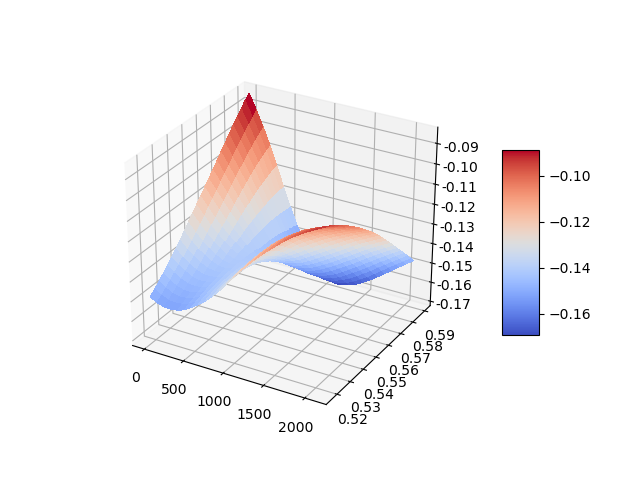

<IPython.core.display.Javascript object>


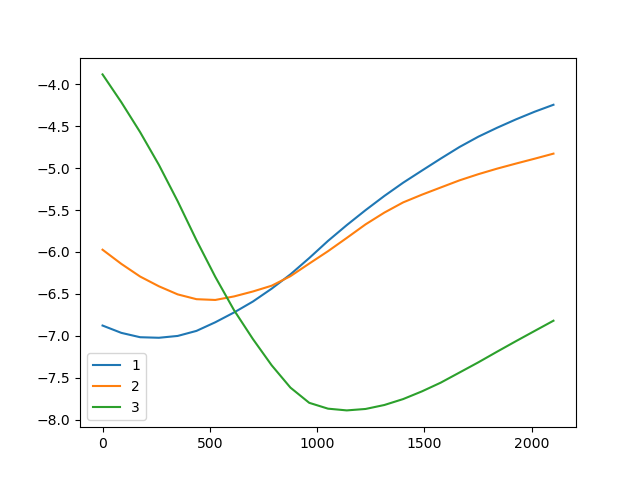

In [37]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook

# Temp = target.Data_Map
# print(Temp.head())
a = 'PPFD_Avg'
b = 'Shrub'
x,y='VPD','VWC'
z=target.target
Select = Temp.loc[(np.abs(Temp[a]-T30[a].quantile(.99))==np.abs(Temp[a]-T30[a].quantile(.99)).min())&\
                (np.abs(Temp[b]-.4)==np.abs(Temp[b]-.4).min()),
                [x,y,z]
               ]
Sel1 = Select.loc[(np.abs(Select['VWC']-T30['VWC'].quantile(0))==np.abs(Select['VWC']-T30['VWC'].quantile(0)).min())]
Sel2 = Select.loc[(np.abs(Select['VWC']-T30['VWC'].quantile(.5))==np.abs(Select['VWC']-T30['VWC'].quantile(.5)).min())]
Sel3 = Select.loc[(np.abs(Select['VWC']-T30['VWC'].quantile(1))==np.abs(Select['VWC']-T30['VWC'].quantile(1)).min())]

# print(Temp)
# Select = Temp[[x,y,z]]
               

# print(target.Data_Map.values.reshape(21,21,21,21,-1).shape)
Select = Select.values.reshape(25,25,-1)
X = Select[:,:,0]
Y = Select[:,:,1]
Z = Select [:,:,2]*mult[target.target]

from matplotlib import colors
norm = colors.DivergingNorm(vmin=-.01, vcenter=0., vmax=.01)

fig = plt.figure()
ax = fig.gca(projection='3d')


surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,#norm = norm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
# a=(Temp.loc[Temp['PPFD_Avg']==Temp['PPFD_Avg'].min()])
# # print(a.loc[a['fco2']<0,['VWC','VPD','Shrub','fco2']].mean())
# plt.figure()
# plt.scatter(T30['AirTC_Avg'],T30['VPD'])
plt.figure()
plt.plot(Sel1['VPD'],Sel1[target.target],label='1')
plt.plot(Sel2['VPD'],Sel2[target.target],label='2')
plt.plot(Sel3['VPD'],Sel3[target.target],label='3')
plt.legend()

In [38]:
Run = []
mult = {'fco2':(1e-6 * 12.0107 *3600),
        'ER':(1e-6 * 12.0107 *3600),
        'fch4':(1e-6 * 12.0107 *3600)}
target = fco2
differential = 'PPFD_Avg'
a,b,c='VWC','VPD','Shrub'
# a,b,c='VPD','VWC','Shrub'
N = 3
Mask = {
    a:[np.round(T30[a].quantile(.5),2),
      np.round(T30[a].quantile(.5),2),np.round(T30[a].quantile(.5),2),],
#     b:[np.round(T30[b].quantile(.25),2),
#       np.round(T30[b].quantile(.5),2),np.round(T30[b].quantile(.75),2),],
    b:[0,400,1500],
    c:[np.round(T30[c].quantile(.5),2),
       np.round(T30[c].quantile(.5),2), np.round(T30[c].quantile(.5),2)],
       }
map_range = [T30[differential].quantile(0),T30[differential].quantile(1)]
Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))

target = fco2
differential = 'VWC'
a,b,c='VPD','PPFD_Avg','Shrub'
N = 3
Mask = {
    a:[np.round(T30[a].quantile(.225),2),#
      np.round(T30[a].quantile(.225),2),np.round(T30[a].quantile(.225),2)],
    b:[T30[b].quantile(.8),
       T30[b].quantile(.8),T30[b].quantile(.8)],
    c:[np.round(0,2),
      np.round(T30[c].quantile(.5),2), np.round(1,2)]
       }
map_range = [T30[differential].quantile(0),T30[differential].quantile(1)]
Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))


target = fco2
differential = 'VWC'
a,b,c='VPD','PPFD_Avg','Shrub'
N = 3
Mask = {
    a:[np.round(T30[a].quantile(.25),2),#np.round(T30[a].quantile(.5),2),
      np.round(T30[a].quantile(.25),2),np.round(T30[a].quantile(.25),2)],
    b:[T30[b].quantile(0),#T30[b].quantile(0),
       T30[b].quantile(0),T30[b].quantile(0)],
    c:[np.round(0,2),# np.round(T30[c].quantile(.35),2),
      np.round(T30[c].quantile(.5),2), np.round(1,2)]
       }
map_range = [T30[differential].quantile(0),T30[differential].quantile(1)]
Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))


C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\sit

<IPython.core.display.Javascript object>


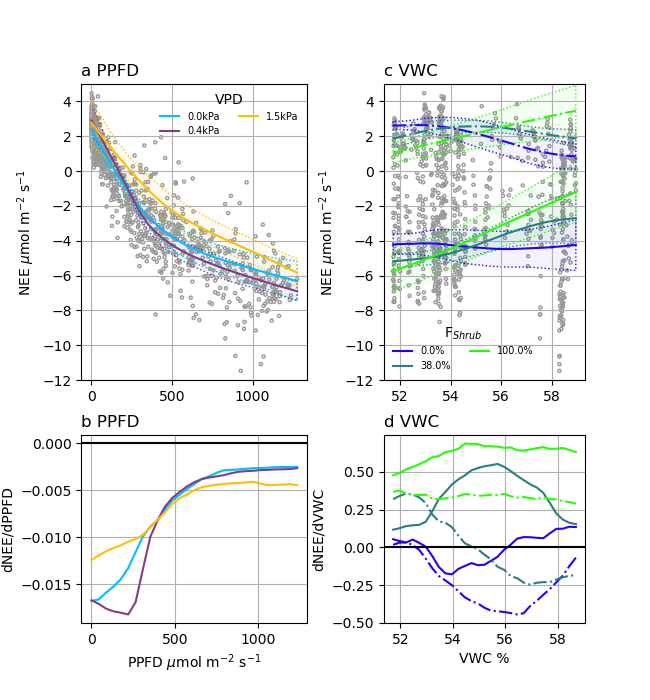

0.0
50.0
100.0
0.0
50.0
100.0
0.0
50.0
100.0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


In [39]:
%matplotlib notebook
fig = plt.figure(figsize=(6.5,7))

# lines = ['-.','-','-.','-','-.','-','-.','-']
lines = ['-','-','-.',':','--']#,'-.','-.','-.','-.']
lbls = ['VPD','Shrub']
Units = ['kPa','%']

# lbla = 'VPD'
# lblb = 'Shrub'
ab = [[.001,100],[100,1]]
# a=1
# b=100
# xlb = xlbs[0]
RunAlt = []
# for i in [0,3,4]:
#     RunAlt.append(Run[i])
ax = []
ax.append(plt.subplot2grid((100, 100), (0, 0),  rowspan=55,colspan=45))
ax.append(plt.subplot2grid((100, 100), (65, 0), rowspan=35,colspan=45))
ax.append(plt.subplot2grid((100, 100), (0, 60), rowspan=55,colspan=40))
ax.append(plt.subplot2grid((100, 100), (65, 60),rowspan=35,colspan=40))
l = 1
for k in range(3):
    tarList,means,columns,Data,target,differential = Run[k]
    n = means.shape[0]
    colors = []
    for x in np.linspace(0,100,n):
        print(x)
        if k == 0:
            colors.append([x/100,(np.abs(x-50)+25)/100,(100-x)/100])
        else:
            colors.append([.15, x/100,(100-x)/100])#(np.abs(x-50)+25)/100])
    if k >1:
        l += 1
        k = 1
    lbla=lbls[k]
    Unit=Units[k]
    a,b = ab[k]
    SCENARIOS = []
    cols = [aliases[col] for col in columns]
    Scenarios = pd.DataFrame(data=means,columns=cols)
    Scenarios = Scenarios.round(2)
    SCENARIOS.append(Scenarios)
    AllData=tarList[0]
    if AllData['VWC'].max()<1:
        AllData['VWC']*=100
#     if AllData['VPD'].max()>10:
#         AllData['VPD']/=1000
#     AllData[target.target]/=mult[target.target]
#     if target == ER:
# #         line = ':'
#     else:
#         line = '-'
    m = 1
    if differential == 'VWC':
        m = 100
#     ax[k*2].scatter(T30[differential]*m,T30[target.target]/mult[target.target]*2,edgecolor=[.6,.6,.6],
#                 facecolor='None',s=5)
    line = lines[l]
    if l < 2:
        ax[k*2].scatter(T30[differential]*m,T30[target.target]/mult[target.target]*2,edgecolor=[.6,.6,.6],
                    facecolor='None',s=5)
    j = 0
#     print(means)
    for key,color in zip(AllData['key'].unique(),colors):
        label = str(np.round(Scenarios[aliases[lbla]].iloc[j]*a,1))+Unit# aliases[lbla]+' = '+
#         aliases[lblb]+' = '+str(int(Scenarios[aliases[lblb]].iloc[j]*b))
        if l > 1:
            label = None
        AllData['Select']=0
        for i,col in enumerate(columns):
            AllData.loc[np.abs(AllData[col]-means[key,i])<1e-5,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Plot(ax[k*2],label,Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,mult=1,alpha = .05)
        ax[k*2+1].plot(Data[differential][:-1],(Data[target.target].diff()/Data[differential].diff()*1)[1:],
               linestyle = line,label = label,color = color)
        j+=1
#         print(means[key,i],Data)
    ax[k*2].legend(fontsize = 7,loc=0,ncol=2,title=aliases[lbla],facecolor='None',edgecolor='None')
    k = l
ax[0].set_ylim(-12,5)
ax[2].set_ylim(-12,5)
ax[1].axhline(y=0, xmin=0, xmax=1,color='k')
ax[3].axhline(y=0, xmin=0, xmax=1,color='k')
ax[0].set_ylabel('NEE ${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[2].set_ylabel('NEE ${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[1].set_xlabel('PPFD ${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[3].set_xlabel('VWC %')
ax[1].set_ylabel('dNEE/dPPFD')
ax[3].set_ylabel('dNEE/dVWC')
ax[0].set_title('a PPFD',loc='left')
ax[2].set_title('c VWC',loc='left')
ax[1].set_title('b PPFD',loc='left')
ax[3].set_title('d VWC',loc='left')
for axes in ax:
    axes.grid()
plt.tight_layout()
plt.savefig('Fig4.png',dpi=300)

In [ ]:
# print(SCENARIOS)

In [ ]:
Run = []
target = fch4
print(target.Best)
# val = target.target
differential = 'VWC'
a,b,c,d='Temp','Shrub','wind_speed','Sedge'
N = 3
Mask = {
    a:[np.round(T30[a].quantile(.25),2) for n in range(N)],
    b:[1,T30[b].mean(),0],
#     c:[np.round(T30[c].quantile(.0),2),np.round(T30[c].quantile(.50),2), np.round(T30[c].quantile(1),2)],
    c:[np.round(1.25,2) for n in range(N)],
    d:[0,T30[d].mean(),1]
#     e:[np.round(T30[e].quantile(1),2), np.round(T30[e].quantile(.5),2), np.round(T30[e].quantile(0),2)]
       }
map_range = [T30[differential].quantile(.0),T30[differential].quantile(1)]
Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))


target = fch4
print(target.Best)
differential = 'Temp'
a,b,c,d='VWC','Shrub','wind_speed','Sedge'
N = 3
Mask = {
    a:[np.round(T30[a].quantile(.4),2) for n in range(N)],
    b:[1,T30[b].mean(),0],
#     c:[np.round(T30[c].quantile(.0),2),np.round(T30[c].quantile(.50),2), np.round(T30[c].quantile(1),2)],
    c:[np.round(1.25,2) for n in range(N)],
    d:[0,T30[d].mean(),1]
#     e:[np.round(T30[e].quantile(1),2), np.round(T30[e].quantile(.5),2), np.round(T30[e].quantile(0),2)]
       }
map_range = [T30[differential].quantile(.0),T30[differential].quantile(1)]
Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(6.5,7))
lbls = [['Sedge','Shrub'],['Sedge','Shrub']]
Lab = ['F$_{Shrub}$ = 100%','F$_{Clim}$','F$_{Sedge}$ = 100%']
# lbla = 'VPD'
# lblb = 'Shrub'
ab = [[100,100],[100,100]]
# a=1
# b=100
# xlb = xlbs[0]

ax = []
ax.append(plt.subplot2grid((100, 100), (0, 0),  rowspan=55,colspan=40))
ax.append(plt.subplot2grid((100, 100), (65, 0), rowspan=35,colspan=40))
ax.append(plt.subplot2grid((100, 100), (0, 55), rowspan=55,colspan=40))
ax.append(plt.subplot2grid((100, 100), (65, 55),rowspan=35,colspan=40))
for k in range(2):
    tarList,means,columns,Data,target,differential = Run[k]
    n = means.shape[0]
    colors = []
    for x in range(1,100,int(100/n)):
        colors.append([x/100,(np.abs(x-50)+25)/100,(100-x)/100])
    A2Colors = colors
    if k >1:
        k = 1
    lbla,lblb=lbls[k][0],lbls[k][1]
    a,b = ab[k]
    SCENARIOS = []
    cols = [aliases[col] for col in columns]
    Scenarios = pd.DataFrame(data=means,columns=cols)
    Scenarios = Scenarios.round(2)
    SCENARIOS.append(Scenarios)
    AllData=tarList[0]
    if AllData['VWC'].max()<1:
        AllData['VWC']*=100
#     if target == ER:
#         line = ':'
#     else:
    line = '-'
    m = 1
    if differential == 'VWC':
        m = 100
    ax[k*2].scatter(T30[differential]*m,T30[target.target]/mult[target.target]*2,edgecolor=[.6,.6,.6],
                facecolor='None',s=5)
    print(T30[differential]*m)
    j = 0
    for key,color in zip(AllData['key'].unique(),colors):
        label = Lab[key]
#         str(int(Scenarios[aliases[lbla]].iloc[j]*a)) +\
#         ' ,'+str(int(Scenarios[aliases[lblb]].iloc[j]*b))
#         aliases[lblb]+#aliases[lbla]+' = '+
        if target == ER_interp:
            label = None
        AllData['Select']=0
        for i,col in enumerate(columns):
            AllData.loc[np.abs(AllData[col]-means[key,i])<1e-4,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Plot(ax[k*2],label,Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,mult=1,alpha = .05)
        ax[k*2+1].plot(Data[differential],(Data[target.target].diff()/Data[differential].diff()),
               linestyle = line,label = label,color = color)
        j+=1
    ax[k*2].legend(fontsize = 7,loc=0,ncol=1,facecolor='None',edgecolor='None')#, title = aliases[lbla]+' ,'+aliases[lblb])
ax[0].set_xlim(51.5,59.2)
ax[1].set_xlim(51.5,59.2)
ax[3].axhline(y=0, xmin=0, xmax=1,color='k')

ax[0].set_ylim(-10,70)
ax[2].set_ylim(-10,60)
ax[1].axhline(y=0, xmin=0, xmax=1,color='k')
ax[3].axhline(y=0, xmin=0, xmax=1,color='k')
ax[0].set_ylabel('NME nmol m$^{-2}$ s$^{-1}$')
ax[2].set_ylabel('NME nmol m$^{-2}$ s$^{-1}$')
ax[1].set_xlabel('VWC %')
ax[3].set_xlabel('T$_s$')
ax[1].set_ylabel('dNME/dVWC')
ax[3].set_ylabel('dNME/dT$_s$')
ax[0].set_title('a VWC',loc='left')
ax[2].set_title('c T$_s$',loc='left')
ax[1].set_title('b VWC',loc='left')
ax[3].set_title('d T$_s$',loc='left')
for axes in ax:
    axes.grid()
plt.tight_layout()
plt.savefig('Fig5.png',dpi=300)

In [ ]:
print(target.RST.params['Inputs'])
target = fch4
# List = []
# n = 3
# Exclude = ['wind_speed','VPD']
Vars = ['VWC','Temp','Sedge','Shrub','wind_speed']
List = [[.5,.53,.55,.58,.6],
        [3,7,12],
        [0,.05,.1,.25,.5,1],
        [0,.1,.25,.4,.6,1],
        np.linspace(T30['wind_speed'].min(),T30['wind_speed'].max(),10),
#         np.linspace(T30['VPD'].min(),T30['VPD'].max(),10),
]
print(List)
Temp = pd.DataFrame(data=np.array(list(itertools.product(*List))),columns=Vars)
target.RST.Data=Temp
target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
target.Map()

In [ ]:

Temp = T30[['VWC','Temp']].dropna()
from scipy.stats import pearsonr
res = pearsonr(Temp['VWC'],Temp['Temp'],)
print(res)

Temp = target.Data_Map
a = 'Shrub'
b = 'Sedge'
c = 'Temp'
x,y='VWC','wind_speed'
z=target.target
Selection = Temp.loc[(np.abs(Temp[a]-.2)==np.abs(Temp[a]-.2).min())&\
                    (np.abs(Temp[b]-.5)==np.abs(Temp[b]-.5).min())&\
                    (np.abs(Temp[c]-7)==np.abs(Temp[c]-7).min()),
#                     (np.abs(Temp[d]-.55)==np.abs(Temp[d]-.55).min()),
                    [x,y,z,'CI']
               ]
# print(Selection)
Select = Selection.values.reshape(5,10,-1)
# print(Select.shape)

# print(Temp)
X = Select[:,:,0]
Y = Select[:,:,1]
Z = Select [:,:,2]*mult[target.target]

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(x)
ax.set_ylabel(y)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()